# Simulating a Poisson Process

Imagine rolling a $6$-sided die for which face number $1$ is colored red and all others are colored black.  We roll it $6$ times a second at regular intervals for $3$ seconds.  We simulate this many times.

We plot 

- the "survival probability" --- the probability that all rolls have been black up to time $t$,
- the distribution of the first time the red face comes up, and
- the distribution of the total number of times the red face comes up in the $3$ seconds.

On average we expect the red face to appear 3 times out of those 3 seconds (on average 1 per second).  However, there is variation for across simulations.

Then we switch to doing the same thing with $N$-sided dice for which the $1$ face is red and all others are black. We roll it $N$ times a second for $3$ seconds.

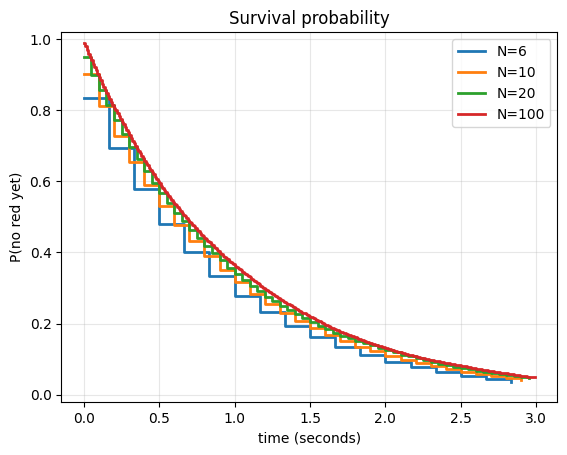

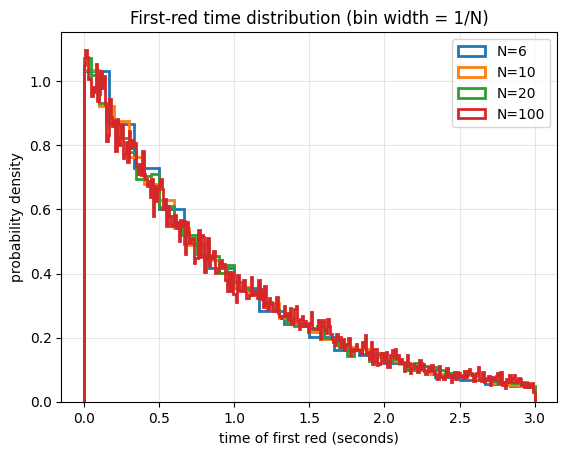

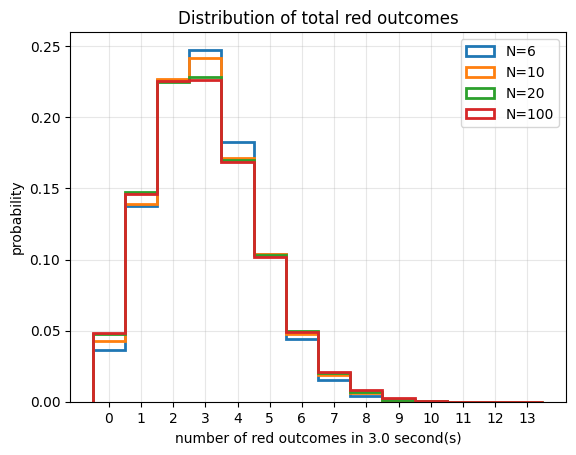

In [20]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng()

def simulate(N=6, T=1.0, nsim=20000):
    """
    Exactly N rolls per second.
    One red face, N−1 non-red faces.
    Rolls occur at times 0, 1/N, 2/N, ..., (nsteps-1)/N.
    If the first roll is red, first_red_time = 0.
    """
    nsteps = int(N * T)
    tgrid = np.arange(0, nsteps) / N

    red_count = np.zeros((nsim, nsteps), dtype=int)
    no_red_yet = np.ones((nsim, nsteps), dtype=bool)
    first_red_time = np.full(nsim, np.inf)

    for sim in range(nsim):
        seen_red = False
        count = 0
        for step in range(nsteps):
            roll = rng.integers(1, N + 1)  # uniform on {1,...,N}
            if roll == 1:
                count += 1
                if not seen_red:
                    first_red_time[sim] = step / N
                    seen_red = True
            red_count[sim, step] = count
            no_red_yet[sim, step] = not seen_red

    survival = no_red_yet.mean(axis=0)          # P(no red yet) at each time
    total_reds = red_count[:, -1].copy()        # total reds over the interval
    return tgrid, survival, first_red_time, total_reds


def plot_for_many_N(N_list=(6, 10, 20), T=1.0, nsim=20000):
    # --- fixed color per N (consistent across all figures) ---
    color_cycle = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    color_for_N = {N: color_cycle[i % len(color_cycle)] for i, N in enumerate(N_list)}

    # run sims once per N and store results
    results = {}
    for N in N_list:
        results[N] = simulate(N=N, T=T, nsim=nsim)

    # =========================================================
    # 1) Survival probabilities on the same axes
    # =========================================================
    plt.figure()
    for N in N_list:
        tgrid, survival, _, _ = results[N]
        plt.step(tgrid, survival, where="post", lw=2, color=color_for_N[N], label=f"N={N}")
    plt.xlabel("time (seconds)")
    plt.ylabel("P(no red yet)")
    plt.ylim(-0.02, 1.02)
    plt.title("Survival probability")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()

    # =========================================================
    # 2) First-red time distributions on the same axes
    #    bins of width 1/N, and first roll red is at time 0
    #    (we plot step histograms so no shading)
    # =========================================================
    plt.figure()
    for N in N_list:
        _, _, first_red, _ = results[N]
        finite_times = first_red[np.isfinite(first_red)]

        eps = 1e-10  # to ensure bin edges don't fall exactly on data points
        bins = np.arange(0-eps, T + 1/N-eps, 1/N)  # exact width 1/N on [0,T]
        plt.hist(
            finite_times,
            bins=bins,
            density=True,
            histtype="step",
            linewidth=2,
            color=color_for_N[N],
            label=f"N={N}"
        )

    plt.xlabel("time of first red (seconds)")
    plt.ylabel("probability density")
    plt.title("First-red time distribution (bin width = 1/N)")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()

    # =========================================================
    # 3) Distribution of total number of reds in T seconds
    #    (step histograms, same axes, legend)
    # =========================================================
    # Choose a common x-range for all N so they truly share axes.
    max_k = 0

    for N in N_list:
        _, _, _, total_reds = results[N]
        current_max = total_reds.max()
        if current_max > max_k:
            max_k = current_max
    bins = np.arange(0, max_k + 2) - 0.5     # bins centered at integers

    plt.figure()
    for N in N_list:
        _, _, _, total_reds = results[N]
        plt.hist(
            total_reds,
            bins=bins,
            density=True,
            histtype="step",
            linewidth=2,
            color=color_for_N[N],
            label=f"N={N}"
        )

    plt.xlabel(f"number of red outcomes in {T} second(s)")
    plt.ylabel("probability")
    plt.title("Distribution of total red outcomes")
    plt.xticks(range(0, max_k + 1))
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()


# Example
plot_for_many_N(N_list=(6, 10, 20, 100), T=3.0, nsim=40000)



# Simulation of Continuous-Time Galton-Watson Processes

**List of significant edits**

- 22 Jan:
   Significant edits

## Gillespie Algorithm

A highly-efficient and simple-to-implement algorithm for simulating Continuous-Time Galton-Watson processes is the **Gillespie Algorithm**.  This algorithm is actually more general and applies whenever we have superposition of Poisson processes.

The key detail underlying the Gillespie Algorithm is that if everything is a Poisson Process, then we can use superposition of Poisson processes to simplify things.  We can calculate the total rate associated with the current state of the system.  Then we choose the waiting time until the next event from the appropriate exponential distribution.  This lets us (exactly) update the time.  Next, we choose the event to occur from the appropriate distribution (proportional to the rates of the events).  Once we identify the event, we update the system state and rpeat these steps.

For this, we will use {prf:ref}`def-CTGW-XFocused` which focuses on just total counts, and combines all of the Poisson processes for each individual into a superposition of Poisson processes for the total population. 

The waiting time $T$ until the time $t_{i+1}=t_i+T$ of the next event can be chosen from an exponential distribution with rate $rX(t_i)$ (this is the continous-time equivalent of the geometric distribution, which corresponds to a survival function of $e^{-r X(t_i) T}$).  Note that different computer languages may want the exponential distribution argument to be the rate $r$ or the scale $1/r$

When an event occurs, $k$ is chosen from the distribution, and then the population size is replaced by $X(t_{i+1})= X(t_i) - 1 + k$.  If $X(t_{i+1})>0$, the algorithm repeats with this new value, otherwise the process has gone extinct and the simulation terminates.

~~~{prf:algorithm} Gillespie Algorithm for a Continuous-time Galton-Watson Process
:label: Alg-Gillespie

**Inputs**

```
float r #rate of one individual's process
function FindK #to generate k given distribution p_k
float maxtime #time to stop (if X not equal to 0)
```

**Algorithm**

```
Set time=0 and PopSize=1
times = [time]
sizes = [PopSize]
While PopSize>0 and time<maxtime:
    TimeToNextEvent = ExponentialRandVar(1/(PopSize*r)) #note, numpy wants 1/rate
    time += TimeToNextEvent
    k = FindK()
    PopSize += k-1
    times.append(time)
    sizes.append(Popsize)
```

**Outputs**
```
return times, sizes
```
~~~

Here is an implementation and sample output.

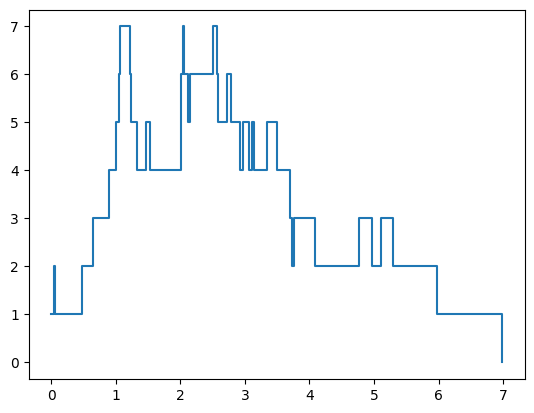

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def Gillespie(r, FindK, maxtime, rng = np.random.default_rng):
    time = 0
    PopSize = 1
    times = [time]
    sizes = [PopSize]
    while PopSize>0 and time<maxtime:
        TimeToNextEvent = rng.exponential(1/(PopSize*r))
        time += TimeToNextEvent
        k = FindK()
        PopSize += k-1
        times.append(time)
        sizes.append(PopSize)
    return times, sizes


beta = 1
gamma = 0.95
r = beta+gamma

rng = np.random.default_rng()
def FindK():
    #k=rng.poisson(1)
    #return k

    if rng.random()<beta/r:
        return 2
    else:
        return 0

times, sizes = Gillespie(r, FindK, maxtime=50, rng=rng)
plt.step(times, sizes, where='post')